# Demo for the Sine Wave Benchmark

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from phaseGP.models import PhaseGP, PhaseTransferGP
from phaseGP.utils import brute_sample_new_points, get_grid, set_seeds
from phaseGP.visualization import model_diagram_plot

from ground_truth.true_phase import true_phase

import warnings
warnings.filterwarnings('ignore')

In [2]:
sources = ["sine_wave_offset_0", "sine_wave_offset_1", "sine_wave_offset_2"]
benchmark_name = "sine_wave_circle"

set_seeds(53)

# Phase Diagram Boundaries (Ignore this code cell)

<Figure size 700x700 with 0 Axes>

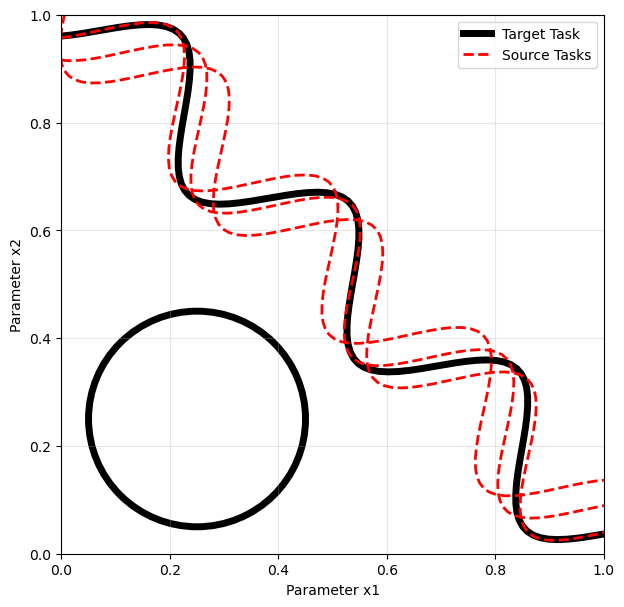

In [3]:
plt.figure(figsize=(7, 7))

# Create x values
x = np.linspace(-2*np.pi, 2*np.pi, 1000)

# Create the original sine wave
y_original = (np.sin(5*np.pi*x)+1)/10 

# Rotation angle in radians
theta = -np.pi/4
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                           [np.sin(theta),  np.cos(theta)]])
# Apply rotation transformation
# For a 2D rotation: x' = x*cos(θ) - y*sin(θ), y' = x*sin(θ) + y*cos(θ)
original_points = np.vstack([x, y_original])

# Apply rotation matrix multiplication: [x', y'] = R(θ) * [x, y]
rotated_points = rotation_matrix @ original_points

# Extract rotated coordinates
x_rotated = rotated_points[0, :]
y_rotated = rotated_points[1, :] +0.9

x_rotated_c = x_rotated.copy()
y_rotated_c = y_rotated.copy()
# Also create a combined plot to show both waves together
plt.figure(figsize=(7, 7))

y_original = (np.sin((5/1.1)*np.pi*(x))+1)/10
original_points = np.vstack([x, y_original])
rotated_points = rotation_matrix @ original_points
x_rotated = rotated_points[0, :]
y_rotated = rotated_points[1, :] +0.9
plt.plot(x_rotated, y_rotated, 'k-', linewidth=5, label='Target Task')
circle = plt.Circle((0.25,0.25), 0.2, color ='k', fill=False, linewidth=5)
ax = plt.gca()
ax.add_patch(circle)

plt.plot(x_rotated_c, y_rotated_c, 'r--', linewidth=2, label='Source Tasks')

y_original = (np.sin(5*np.pi*(x+2*np.pi/2))+1)/10
original_points = np.vstack([x, y_original])
rotated_points = rotation_matrix @ original_points
x_rotated = rotated_points[0, :]
y_rotated = rotated_points[1, :] +0.9
plt.plot(x_rotated, y_rotated, 'r--', linewidth=2)

y_original = (np.sin(5*np.pi*(x+4*np.pi/2))+1)/10
original_points = np.vstack([x, y_original])
rotated_points = rotation_matrix @ original_points
x_rotated = rotated_points[0, :]
y_rotated = rotated_points[1, :] +0.9
plt.plot(x_rotated, y_rotated, 'r--', linewidth=2)


plt.grid(True, alpha=0.3)
plt.xlabel('Parameter x1')
plt.ylabel('Parameter x2')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()

# Run Active learning loop on source tasks

In [4]:
import torch

def source_active_learning_loop(benchmark_name, n_points=50, n_initial_points = 10, candidate_size = 20, test_size = 100):
    train_x = torch.rand(n_initial_points, 2)
    train_y = true_phase(train_x, benchmark_name=benchmark_name )

    candidate_grid = get_grid(0,1, candidate_size)
    test_grid = get_grid(0,1, test_size)
    test_y = true_phase(test_grid, benchmark_name=benchmark_name )

    error_curve = []
    train_x = train_x
    train_y = train_y
    test_grid = test_grid
    
    for i in tqdm(range(n_points)):
        model = PhaseGP(train_x, min_scale=0, max_scale=1)
        model.fit(train_x, train_y)

        new_point, new_index_list = brute_sample_new_points(model, candidate_grid, train_x, return_index=True)
        mask = torch.ones(len(candidate_grid), dtype=torch.bool)
        mask[new_index_list] = False
        candidate_grid = candidate_grid[mask]

        new_point_y = true_phase(new_point, benchmark_name=benchmark_name)
        train_x = torch.cat([train_x, new_point], dim=0)
        train_y = torch.cat([train_y, new_point_y], dim=0)

        pred_points = model.predict(test_grid)
        corect_predictions = pred_points != test_y
        error = torch.mean(corect_predictions.float())
        error_curve.append(error)
    return model, error_curve, train_x

In [5]:
source_model_list = []

for source_benchmark_name in sources:
    model, _, _ = source_active_learning_loop(source_benchmark_name)
    source_model_list.append(model)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:35<00:00,  1.43it/s]


# Run Active Learning on Vanilla GP Implementation

In [6]:
benchmark_name = "sine_wave_circle"
vanilla_model, vanilla_error_curve, vanilla_sampled_points = source_active_learning_loop(benchmark_name)

100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


# Run Active Learning on TL Model 

In [7]:
def tl_active_learning_loop(source_model_list, benchmark_name, n_points=50, n_initial_points = 10, candidate_size = 20, test_size = 100, prior_aggregation="linear"):
    train_x = torch.rand(n_initial_points, 2)
    train_y = true_phase(train_x, benchmark_name=benchmark_name )

    candidate_grid = get_grid(0,1, candidate_size)
    test_grid = get_grid(0,1, test_size)
    test_y = true_phase(test_grid, benchmark_name=benchmark_name )

    error_curve = []
    train_x = train_x
    train_y = train_y
    test_grid = test_grid

    for i in tqdm(range(n_points)):
        model = PhaseTransferGP(source_model_list, train_x, min_scale=0, max_scale=1, prior_aggregation=prior_aggregation)
        model.fit(train_x, train_y)

        new_point, new_index_list = brute_sample_new_points(model, candidate_grid, train_x, return_index=True, distance_acq=True)
        mask = torch.ones(len(candidate_grid), dtype=torch.bool)
        mask[new_index_list] = False
        candidate_grid = candidate_grid[mask]

        new_point_y = true_phase(new_point, benchmark_name=benchmark_name)
        train_x = torch.cat([train_x, new_point], dim=0)
        train_y = torch.cat([train_y, new_point_y], dim=0)

        pred_points = model.predict(test_grid)

        corect_predictions = pred_points != test_y
        error = torch.mean(corect_predictions.float())
        error_curve.append(error)
    return model, error_curve, train_x

### Single Source PhaseTransfer

In [8]:
tl_single_model, tl_single_error_curve, tl_single_sampled_points = tl_active_learning_loop([source_model_list[0]], benchmark_name)

100%|██████████| 50/50 [01:21<00:00,  1.64s/it]


### Multi Source PhaseTransfer (Best performing model in general)

In [9]:
multi_tl_model, multi_tl_error_curve, multi_tl_sampled_points = tl_active_learning_loop(source_model_list, benchmark_name, prior_aggregation="linear")

100%|██████████| 50/50 [03:05<00:00,  3.70s/it]


# Phase Diagram Drawing Results

In [10]:
def draw_boundary(ax, color="k"):
    #True Boundary
    x = np.arange(-0.5, 1.5, 0.01)
    y = (np.sin((5/1.1)*np.pi*(x))+1)/10

    coords = np.vstack((x,y))
    theta = np.pi/4
    rotation = np.array([[np.cos(theta) , np.sin(theta)],
                        [-np.sin(theta), np.cos(theta)]])
    rotated_coords = rotation @ coords
    ax.plot(rotated_coords[0], rotated_coords[1] + 0.9, color+'--', linewidth=1.5, label='True Boundary')
    
    radius = 0.2
    circle = plt.Circle([0.25,0.25], radius, fill=False, linestyle='--', 
                            edgecolor=color, linewidth=1.5)
    ax.add_patch(circle)
    return ax

def draw_diagram_and_boundary(model, points=None, plot_type="phase", n_initial_points = 10 ,plot_boundary = False, figsize=(7,6), title=None,
                              xlabel="Parameter 1", ylabel="Parameter 2"):
    fig, ax = model_diagram_plot(model, plot_type=plot_type, x_min =0, x_max = 1, xlabel=xlabel, ylabel=ylabel,
                                 sampled_points=points, plot_boundary=plot_boundary, figsize=figsize, title=title)
    
    if(plot_type != "acquisition"):
        #True Boundary in black
        
        ax = draw_boundary(ax, color="k")
        if(plot_type=="phase"):
            ax.scatter(points[:n_initial_points,0], points[:n_initial_points,1], c='blue', s=50, marker='o', label='Initial points')
            ax.scatter(points[n_initial_points:,0], points[n_initial_points:,1], c='red', s=80, marker='x', label='Sampled points')
            plt.legend(fontsize=15)
    else:
        #True Boundary in white
        ax = draw_boundary(ax, color="w")
        plt.legend(fontsize=15)
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    colorbar_ax = fig.axes[-1]
    colorbar_ax.tick_params(labelsize=15)  # For ticks

    # For the main colorbar label
    colorbar_ax.set_ylabel(colorbar_ax.get_ylabel(), fontsize=15)
    #fig.axes[1].tick_params(labelsize=15)
    #fig.axes[0].tick_params(axis="both", labelsize=15)
    plt.tight_layout()
    

### Plot the phase diagram

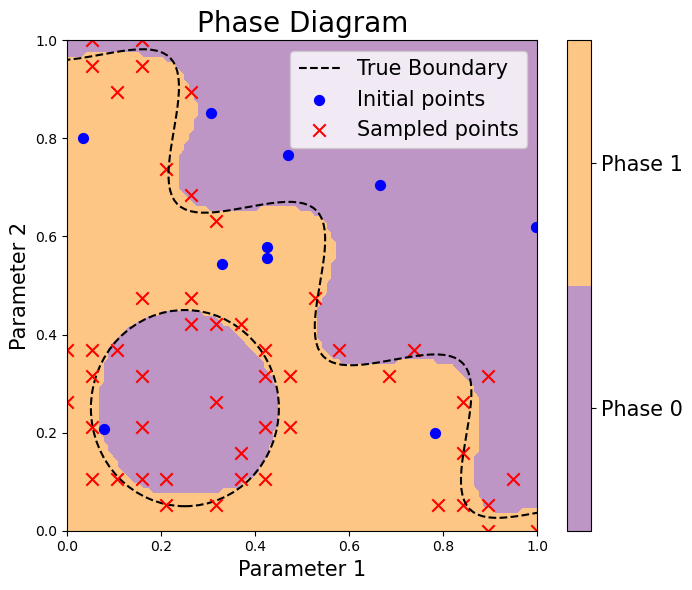

In [11]:
draw_diagram_and_boundary(multi_tl_model, multi_tl_sampled_points, figsize = (7,6), plot_type="phase")

### Plot the Probability diagram

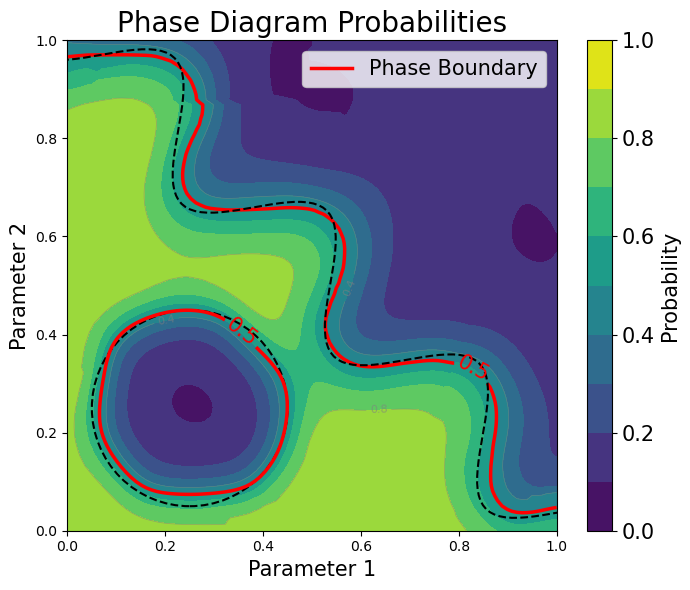

In [12]:
draw_diagram_and_boundary(multi_tl_model, multi_tl_sampled_points, figsize = (7,6), plot_type="probability", plot_boundary=True)

### Plot the Acquisition values

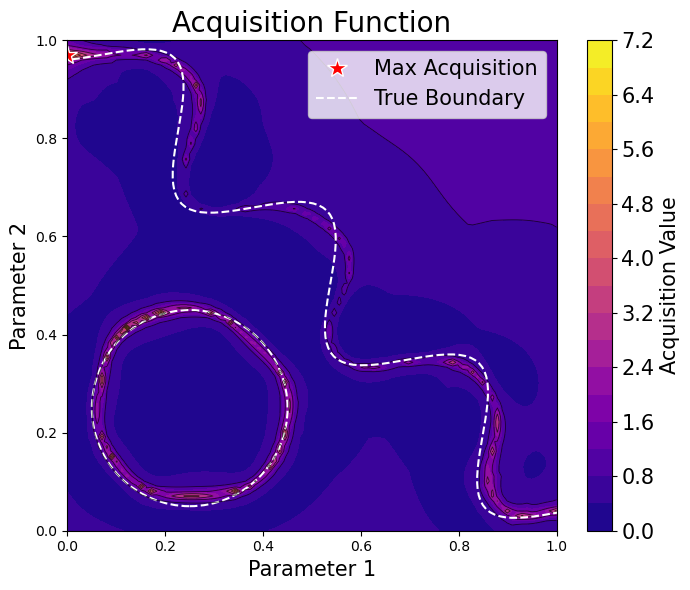

In [13]:
draw_diagram_and_boundary(multi_tl_model, multi_tl_sampled_points, figsize = (7,6), plot_type="acquisition")

### Plot the weights

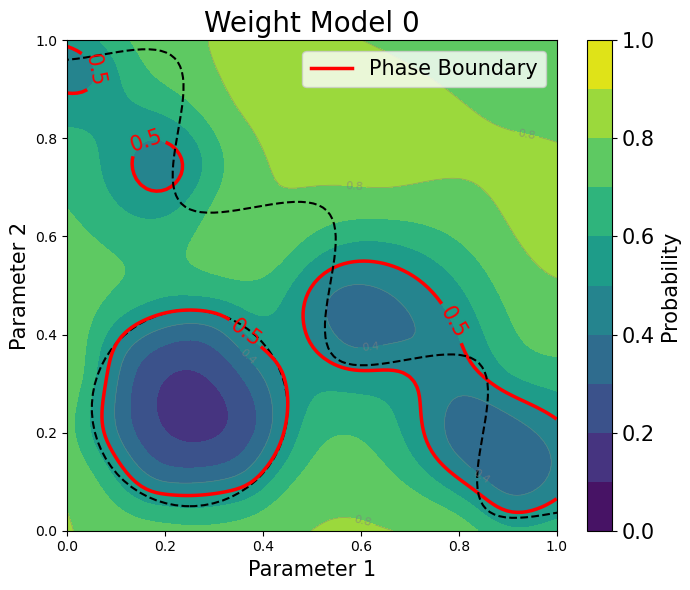

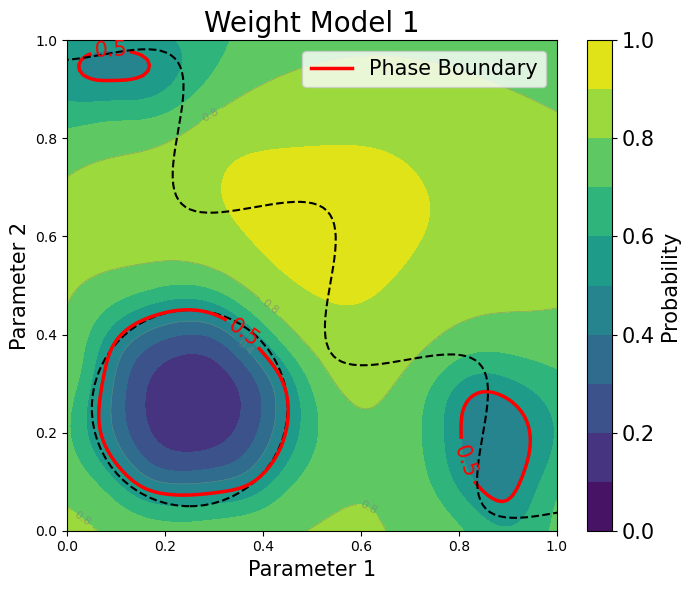

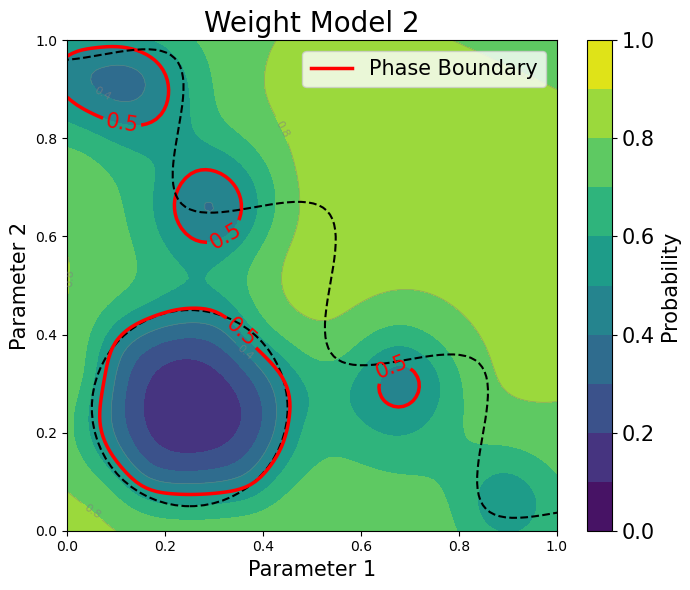

In [14]:
for i, weight_model in enumerate(multi_tl_model.weight_model_list):
    draw_diagram_and_boundary(weight_model, figsize = (7,6), plot_type="probability", plot_boundary=True, title=f"Weight Model {i}")

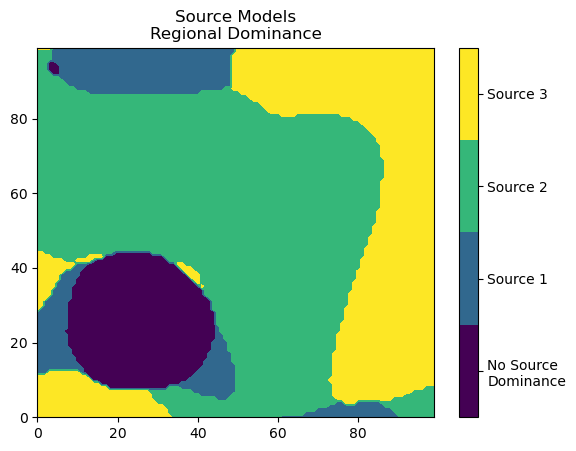

In [15]:
grid_points, x_coords, y_coords = get_grid(
        0, 1, 
        grid_size=100, return_coordinates=True)

weight_probabilities = np.array([model.predict_proba(grid_points) for model in multi_tl_model.weight_model_list])

weight_probabilities_index = np.argmax(weight_probabilities, axis=0)
weight_probabilities = weight_probabilities[weight_probabilities_index, np.arange(len(weight_probabilities_index))]

weight_probabilities_index += 1
weight_probabilities_index[weight_probabilities < 0.5] = 0
weight_probabilities_index = weight_probabilities_index.reshape(100,100).T

plt.contourf(weight_probabilities_index, levels=[-0.5,0.5,1.5,2.5,3.5], cmap=plt.get_cmap('viridis', 4))
cbar = plt.colorbar(ticks=[0, 1, 2, 3])
cbar.ax.set_yticklabels(['No Source\nDominance', 'Source 1', 'Source 2', 'Source 3'])
plt.title("Source Models\nRegional Dominance")
plt.show()

# Error Curves Results

Vanilla acc: 0.05820000171661377
First under 0.1 error: 35
First under 0.05 error: -1
----------------------
Single Source
PhaseTransfer acc: 0.048500001430511475
First under 0.1 error: 9
First under 0.05 error: 49
----------------------
Multi Source
PhaseTransfer acc: 0.03550000116229057
First under 0.1 error: 9
First under 0.05 error: 33
----------------------
----------------------


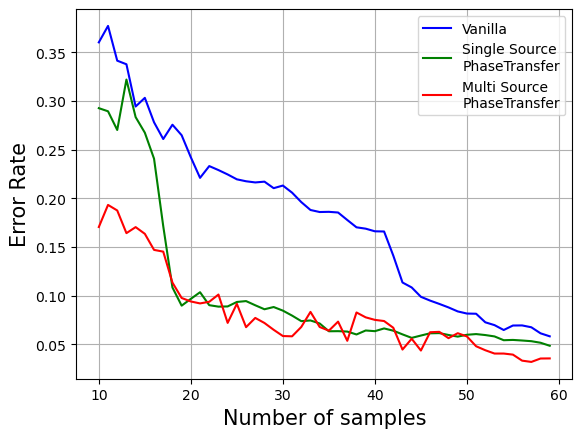

In [16]:

acc_threshold = 0.05


label = ["Vanilla", "Single Source\nPhaseTransfer", "Multi Source\nPhaseTransfer"]
color = ["blue", "green", "red", "aqua"]
error_curves = [np.array(vanilla_error_curve), np.array(tl_single_error_curve), np.array(multi_tl_error_curve)]
points = np.arange(len(vanilla_error_curve))

for i, error_curve in enumerate(error_curves):
    plt.plot(points+10, error_curve, label=label[i], color=color[i])
    plt.legend(fontsize = 10)

    first_index = np.argmax(error_curve < acc_threshold*2) if np.any(error_curve< acc_threshold*2) else -1
    print(f"{label[i]} acc: {error_curve[-1]}")
    print(f"First under {acc_threshold*2} error: {first_index}")
    first_index = np.argmax(error_curve < acc_threshold) if np.any(error_curve < acc_threshold) else -1
    print(f"First under {acc_threshold} error: {first_index}")
    print("----------------------")

print("----------------------")
plt.xlabel("Number of samples", fontsize=15)
plt.ylabel("Error Rate", fontsize=15)
plt.grid()
plt.show()
  